# import libraries

In [1]:
import tensorflow as tf
import os
import numpy as np
import math
import glob
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, Lambda
from tensorflow.keras.layers import Conv2D, Dense,Input, Dropout, Flatten, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import RepeatVector, MaxPooling2D, LSTM, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K, layers

In [2]:
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import matplotlib.pyplot as plt

# Extract text and file name from word text file

In [4]:
# d is the dictionary of key:file name, value:word text  
d = {}

# status of the word means that properly segmented or not. Two status - err:means word not segmented properly, ok:means word properly segmented.
# This contain only those word text which status is ok.
status = []

#key of dictionary which is file name
keys = []
with open('word.txt') as f:
    for line in f:
        #split the line
        line = line.split(' ')
        status.append(line[1])
        if line[1] == 'ok':
            key = line[0]
            keys.append(line[0])
            text = line[8]
            text = text[:-1]
            d[key] = text
    f.close()
# Ground truth text. Actual word
gtText = []
for _, val in d.items():
    gtText.append(val)

In [5]:
len(gtText)

96431

# Check how many types of character are used

In [6]:
vocab = set("".join(map(str, gtText)))
print(sorted(vocab))

['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
len(vocab)

78

# Encode text into digit

In [8]:
char_list = sorted(vocab)

def encode_to_labels(txt):

    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [9]:
# Check - encode the text.
encode_to_labels("HELLO")

[33, 30, 37, 37, 40]

In [10]:
# max length of ground truth text
max_label_len = max([len(str(text)) for text in gtText])

In [11]:
max_label_len

21

# path of image of text

In [40]:

file_path = os.path.join('words_data', '*')
path = glob.glob(file_path)
path.sort()

In [41]:
# get those image which status is ok in ascii text file
image_path = []
for img_path in path:
    paths = img_path.split('\\')[1].split('.')[0]
    if paths in keys:
        image_path.append(img_path)

In [42]:
len(image_path)

96431

# split the data for training and validation

In [43]:
train_final_paths = image_path[ : int(len(image_path) * 0.90)]
train_final_texts = gtText[ : int(len(gtText) * 0.90)]

val_final_paths = image_path[int(len(image_path) * 0.90) : ]
val_final_texts = gtText[int(len(gtText) * 0.90) : ]

In [44]:
train_final_paths[1]

'words_data\\a01-000u-00-01.png'

# Preprocess the image for training

In [45]:
# In this process the image resize without distortion

def process(img_path):
    image_path = []
    for path in img_path:

        img = cv2.imread(path, 0)

        (wt, ht) = (128, 32)
        (h, w) = img.shape
        fx = w / wt
        fy = h / ht
        f = max(fx, fy)
                
        newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
                
        img = cv2.resize(img, newSize)
        img = img/255
                    
        target = np.ones([ht, wt]) * 255
                
        if newSize[1] < 32:
            img = np.concatenate((img, target[newSize[1]:32]), axis=0)    
                
        if newSize[0] < 128:
            img = np.concatenate((img, target[:,newSize[0]:128]), axis=1)

        img = cv2.transpose(img)

        img = img.reshape(128, 32, 1)

        image_path.append(img)
    return image_path

In [46]:
# preprocess all the training and vslidation image data
train_final_path = process(train_final_paths)
val_final_path = process(val_final_paths)

# Generator

In [47]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
#       create batch
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        label_length = []
        input_length = []

        for img, text in zip(batch_paths, batch_texts):

            images.append(img)
            training_txt.append(encode_to_labels(text))
            label_length.append(len(text))
            input_length.append(32)
        
        return [np.array(images), 
                  pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
                  np.array(input_length), 
                  np.array(label_length)], np.zeros(len(images))

In [54]:
batch_size = 200
train_generator = My_Generator(train_final_path, train_final_texts, batch_size)
val_generator = My_Generator(val_final_path, val_final_texts, batch_size)

# Neural Network Model

In [49]:
input_shape = Input(shape=(128, 32, 1))
# First layer
conv1 = Conv2D(32, (5, 5), activation='relu', padding = 'SAME', strides = (1, 1))(input_shape)
batch1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2),strides = (2, 2), padding = 'valid')(batch1)

# Second layer
conv2 = Conv2D(64, (5, 5), activation='relu', padding = 'SAME', strides = (1, 1))(pool1)
batch2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2,2),strides = (2, 2), padding = 'valid')(batch2)

# Third layer
conv3 = Conv2D(128, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool2)
batch3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch3)

# Fourth layer          
conv4 = Conv2D(128, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool3)
batch4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch4)

# Fifth layer             
conv5 = Conv2D(256, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool4)
batch5 = BatchNormalization()(conv5)
pool5 = MaxPooling2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch5)

# Reduce the dimension of output of fifth layer
cnn_input = tf.squeeze(pool5, [2])

# The output of convolutional layer is the input of bidirectional LSTM layer
forward_lstm = CuDNNLSTM(256, return_sequences=True)
backward_lstm = CuDNNLSTM(256, return_sequences=True, go_backwards=True)

bidirectional = Bidirectional(forward_lstm, backward_layer=backward_lstm)(cnn_input)

# output of model
output_layer = Dense(len(char_list)+1, activation='softmax')(bidirectional)

my_model = Model(inputs = input_shape, outputs = output_layer)

In [50]:
my_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 32, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 32, 32)       832       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 32, 32)       128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 16, 64)        51264     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 16, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 8, 64)         0   

# ctc loss function

In [51]:
# Encoded word text is the labels
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
# Input length which is 32
input_length = Input(name='input_length', shape=[1], dtype='int64')
# label_length is the length of word text
label_length = Input(name='label_length', shape=[1], dtype='int64')

# ctc_batch_cost use from keras backend
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([output_layer, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[input_shape, labels, input_length, label_length], outputs=loss_out)

# Compile the model

In [52]:
# weight file 
file_path = "C_LSTM_best.hdf5"
from tensorflow.keras.optimizers import RMSprop

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = RMSprop(0.001), metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

# Train the model

In [ ]:
epochs = 10

history = model.fit_generator(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths),
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths),
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/10
15596/86787 [====>.........................] - ETA: 8:58:26 - loss: 1.6730 - accuracy: 0.7223

# Preprocess the image befor testing

In [70]:
def pre_process_image(path):
    
#     img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    img = path
        
    (wt, ht) = (128, 32)
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
                
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
                
    img = cv2.resize(img, newSize)
    img = img/255
                    
    target = np.ones([ht, wt]) * 255
                
    if newSize[1] < 32:
        img = np.concatenate((img, target[newSize[1]:32]), axis=0)    
                
    if newSize[0] < 128:
        img = np.concatenate((img, target[:,newSize[0]:128]), axis=1)
        
    img = cv2.transpose(img)

    img = img.reshape(128, 32, 1)

    
    return img

# Load the weight file in the model

In [50]:
my_model.load_weights('C_LSTM_best.hdf5')

# Prediction

In [72]:
def predict_output(img):
    # predict outputs
    prediction = my_model.predict(np.array([img]))

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True, beam_width=100, top_paths=1)[0][0])

    ## get the final text
    for x in out:
#         print("predicted text = ", end = '')
        for p in x:
            
            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print(' ', end='')

# Word prediction

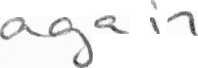



predicted text = again 

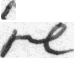



predicted text = 'e 

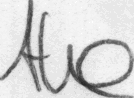



predicted text = the 



predicted text = . 



predicted text = was 

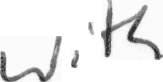



predicted text = with 



predicted text = , 

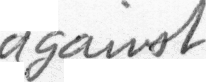



predicted text = against 

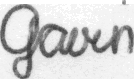



predicted text = Goon 

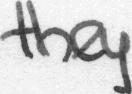



predicted text = they 

In [65]:
from IPython.display import display
from random import randrange
from PIL import Image

for i in range(10):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    predict_output(test_img)

# Predict paragraph of text

# Segmention of word from an image

In [17]:
# Line segmention
def line_segment(image):
    #conver image into gray image
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


    #binary threshold
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

    #dilation
    kernel = np.ones((15,100), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    #find contours
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return ctrs

# After line segmention, word segmention
def word_segment(line):
    #convert image into gray image
    gray = cv2.cvtColor(line,cv2.COLOR_BGR2GRAY)


    #binary
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

    #dilation
    kernel = np.ones((15,21), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    #find contours
    cntrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return cntrs

# Extract each word from image in sorted manner

In [85]:
image = cv2.imread('h01-004.png')

#find contours of line
ctrs_line = line_segment(image)

line_img = []

for i, ctr in enumerate(ctrs_line):
    x, y, w, h = cv2.boundingRect(ctr)
    roi = image[y:y+h, x:x+w]
    
    # this is used for making line in sorted 
    line_img.append((y, roi))
line_img = sorted(line_img, key=lambda entry:entry[0])

words = []

for line in line_img:
    img = line[1]
    
#     conours of each words
    cntrs_word = word_segment(img)
    word_img = []
    
    for i, cntr in enumerate(cntrs_word):
        x, y, w, h = cv2.boundingRect(cntr)
        roi = img[y:y+h, x:x+w]
        
        cv2.rectangle(img,(x,y),( x + w, y + h ),(255,0,0),1)
        
        # this is used for sorting words
        word_img.append((math.sqrt(x*x + y*y), roi))
    word_img = sorted(word_img, key=lambda entry:entry[0])
    
#   append all word into a list
    for w in word_img:
        words.append(w[1])

# cv2.imshow('segment no:',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [86]:
word = []

# convert all word image into gray
for i in range(len(words)):
    w = cv2.cvtColor(words[i], cv2.COLOR_BGR2GRAY)
    word.append(w)

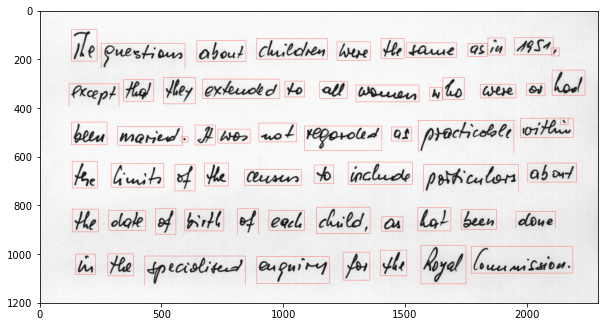

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(image)

# Recognition of words from hand written text image

In [88]:
for i in range(len(word)):
    test_img = pre_process_image(word[i])
    predict_output(test_img)


, The questions about children Were Hae samie a5 in Mva95a "r except thot tey extended to ald Wecmen t h were ar had been maried To It wwos not regarded aaf practicdale woithin T tre limits of the ,eusirs to include porticulars about the ate of irth of eeach chuild aas lhat been ddone in the specealivend enquirs for the Raygal Comumissioum 